In [87]:
import os
import json
import numpy as np
import heapq
from matplotlib import colors
import matplotlib.pyplot as plt
import torch
import networkx as nx
from networkx.readwrite import json_graph

# 1. Make Graph

In [88]:
def make_graph(num_nodes, num_edges):
    G = nx.DiGraph()

    nodes = [chr(i) for i in range(65, 65+num_nodes)]
    G.add_nodes_from(nodes)
    edges = [(np.random.choice(nodes), np.random.choice(nodes), np.random.randint(1, 100)) for _ in range(num_edges)]
    
    while True:
        edges = list(set(edges))
        if len(edges) == num_edges:
            break
        edges.append((np.random.choice(nodes), np.random.choice(nodes), np.random.randint(100)))
    
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)
    
    heuristic_table = {node : np.random.randint(0,10) for node in nodes}

    return G, nodes, edges, heuristic_table

In [111]:
def plot_graph(G, path = None, start = None, goal = None, checking_edges = None, weight_tag = True, llm_nodes = None):

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))

    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, arrows=True,
                        connectionstyle='arc3,rad=0.1')

    if path is not None:
        path_edges = list(zip(path, path[1:]))

        print(f"A* 경로 : {path}")
        nx.draw_networkx_edges(G, pos, edgelist=checking_edges, edge_color='orange', alpha= 0.3, width=4,
                            arrows=True, connectionstyle='arc3,rad=0.1')
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2,
                            arrows=True, connectionstyle='arc3,rad=0.1')
        if llm_nodes is None :
            title = f"A* Shortest Path from {start} to {goal}"
            
        else:
            title = f"LLM A* Shortest Path from {start} to {goal} (llm nodes = {llm_nodes})"
    else :
        title = "our graph"
        

    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    if weight_tag:
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green')

    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(title+".png",dpi=200)
    plt.show()

In [100]:
num_nodes = 26
num_edges = 200
G, nodes, edges, heuristic_table = make_graph(num_nodes, num_edges)

In [105]:
with open("graph_1.json", "r") as json_file:
    j = json.load(json_file)

G = json_graph.node_link_graph(j)
G

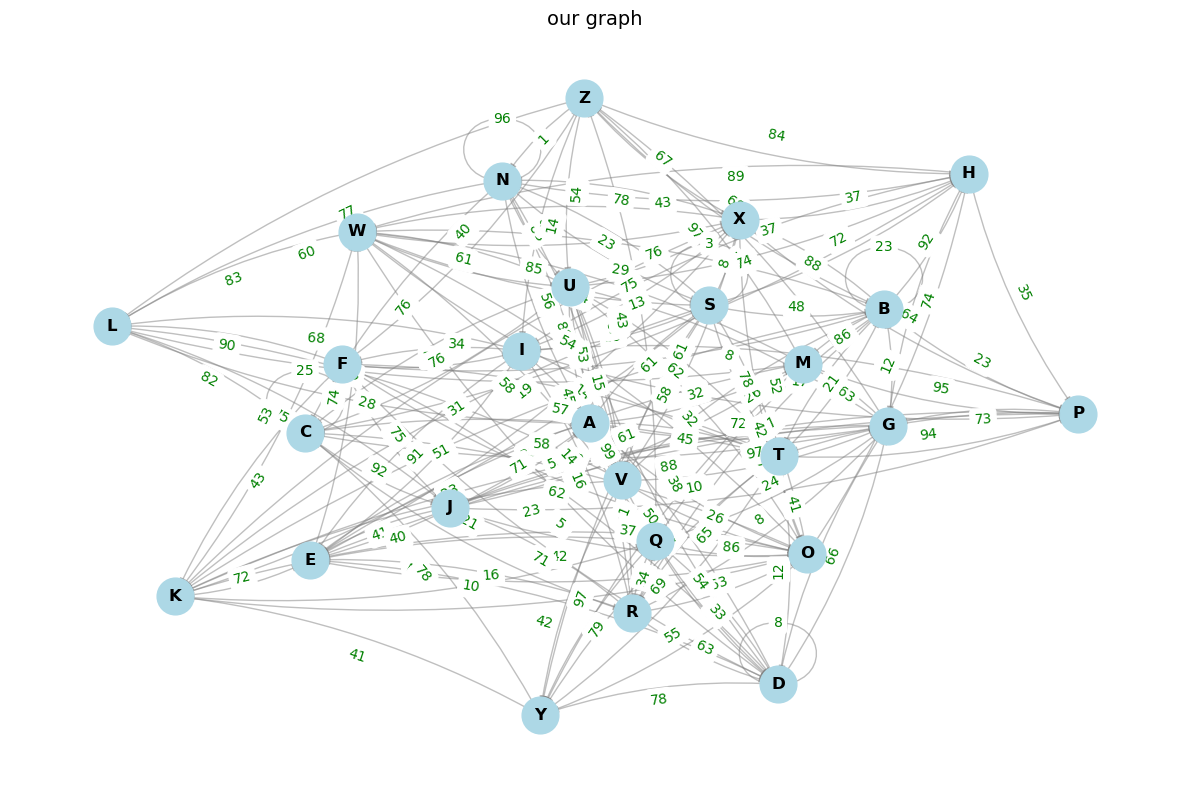

In [112]:
plot_graph(G)

In [106]:
#save graph as json
graph_json = json_graph.node_link_data(G)
with open("graph_1.json", "w") as json_file:
    json.dump(graph_json, json_file)


# 2. A* Algorithm

In [113]:
def astar(G, start, goal, heuristic):
    count = 0
    checking_edges = set()

    open_set = []
    heapq.heappush(open_set, (heuristic[start], 0, start))

    came_from = {}
    g_score = {node: float('inf') for node in G.nodes}
    g_score[start] = 0

    f_score = {node: float('inf') for node in G.nodes}
    f_score[start] = heuristic[start]

    visited = set()

    while open_set:
        _, current_g, current = heapq.heappop(open_set)

        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], current_g, count, list(checking_edges)

        visited.add(current)

        for neighbor in G.successors(current):
            count = count + 1
            if neighbor in visited:
                continue

            tentative_g = g_score[current] + G[current][neighbor]['weight']
            checking_edges.add((current, neighbor))
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic[neighbor]
                heapq.heappush(open_set, (f_score[neighbor], tentative_g, neighbor))

    return None, None, count, list(checking_edges)


Count :  237
Cost :  93
# of Checking edges 78
A* 경로 : ['A', 'U', 'W', 'D', 'F', 'Z']


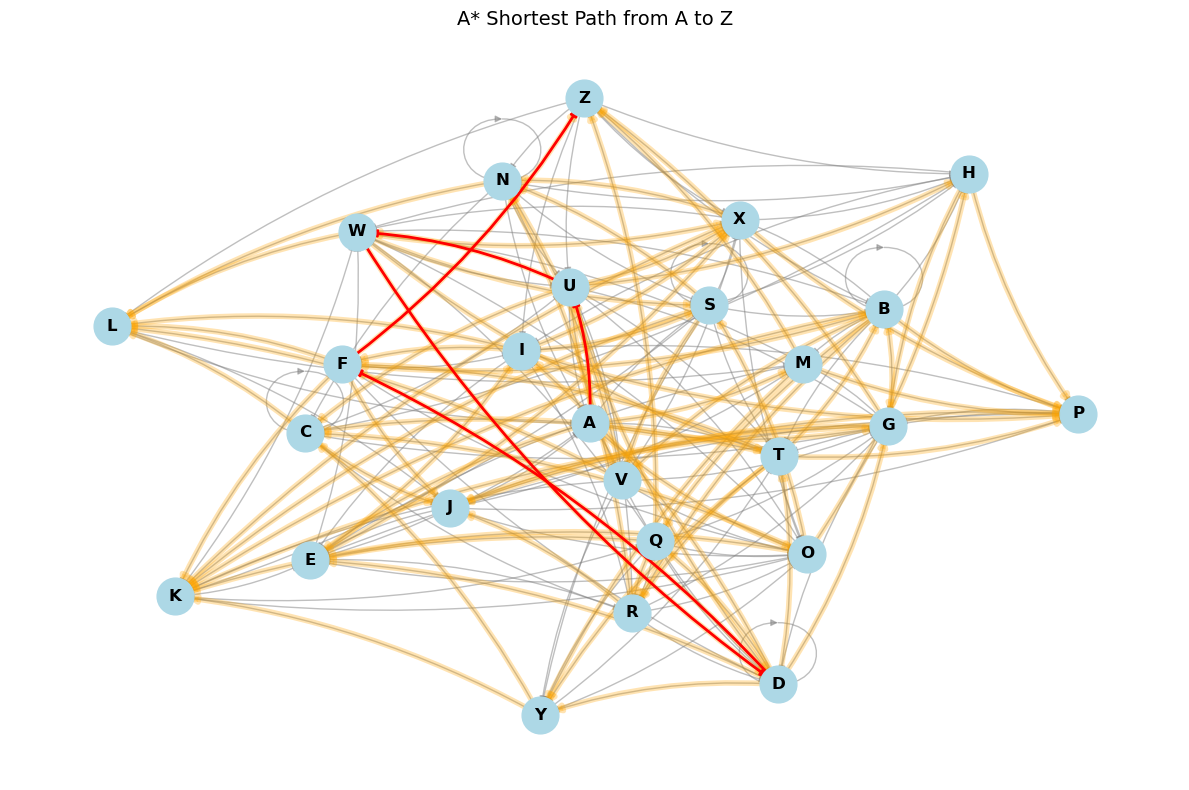

In [114]:
start, goal = 'A', 'Z'
path, cost, count, checking_edges= astar(G, start, goal, heuristic_table)
print("Count : ",count)
print("Cost : ",cost)
print("# of Checking edges", len(checking_edges))
plot_graph(G, path=path, start=start, goal=goal, checking_edges= checking_edges, weight_tag= False)

# 3. LLM A* Algorithm

In [115]:
def llm_astar(G, start, goal, heuristic, llm_nodes):

    points = llm_nodes.copy()
    points.insert(0, start)
    points.append(goal)

    cum = 0
    path = []
    count = 0
    checking_edges = set()

    for i in range(len(points)-1):
        s = points[i]
        e = points[i+1]

        open_set = []
        heapq.heappush(open_set, (heuristic[s], 0, s))

        came_from = {}
        g_score = {node: float('inf') for node in G.nodes}
        g_score[s] = 0

        f_score = {node: float('inf') for node in G.nodes}
        f_score[s] = heuristic[s]

        visited = set()

        while open_set:
            _, current_g, current = heapq.heappop(open_set)

            if current == e:
                p = [current]
                while current in came_from:
                    current = came_from[current]
                    p.append(current)
                path += p[::-1]
                if path[-1] in llm_nodes:
                    path.pop()
                cum += current_g
                break

            visited.add(current)

            for neighbor in G.successors(current):
                count = count + 1
                if neighbor in visited:
                    continue

                tentative_g = g_score[current] + G[current][neighbor]['weight']
                checking_edges.add((current, neighbor))
                if tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score[neighbor] = tentative_g + heuristic[neighbor]
                    heapq.heappush(open_set, (f_score[neighbor], tentative_g, neighbor))

    return path, cum, count, list(checking_edges)


### LLM nodes 1 : 'I'

Count :  125
Cost :  109
# of Checking edges 81
A* 경로 : ['A', 'E', 'I', 'F', 'Z']


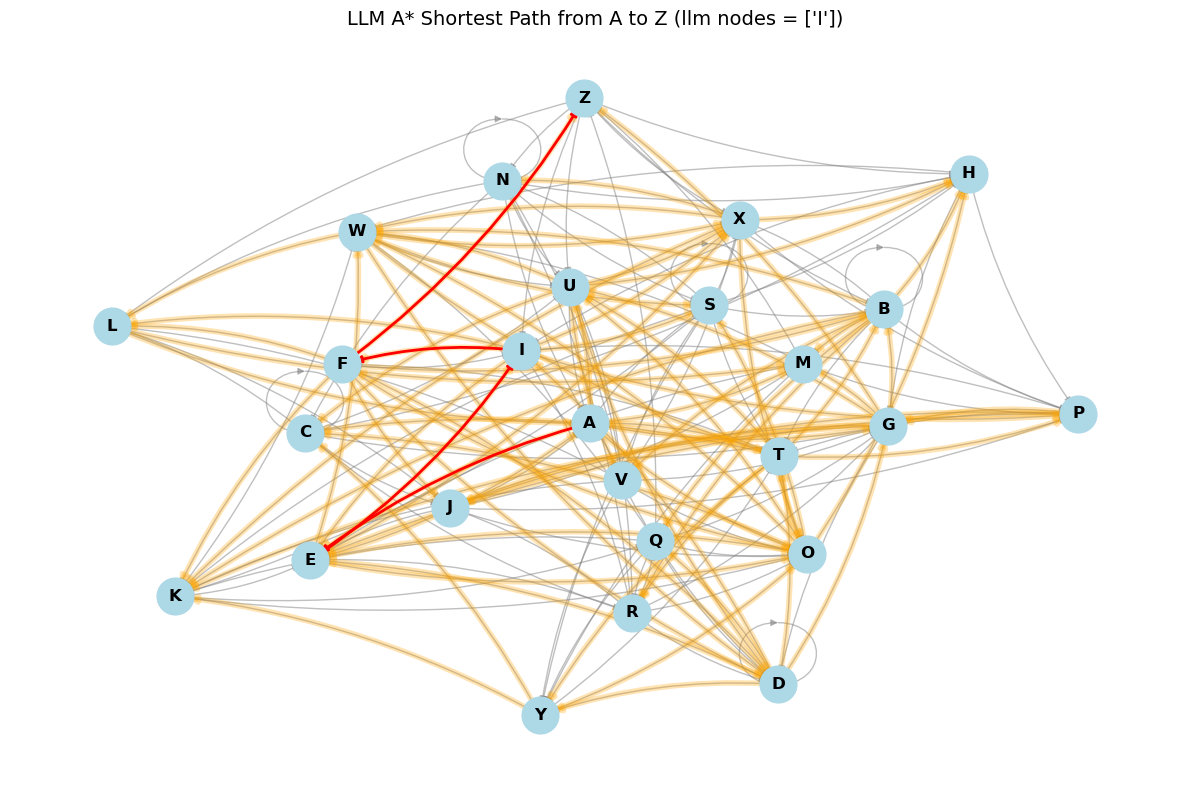

In [116]:
start, goal = 'A', 'Z'
llm_nodes = ['I']
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, llm_nodes)
print("Count : ",count)
print("Cost : ",cost)
print("# of Checking edges", len(checking_edges))
plot_graph(G, path=path, start=start, goal=goal, checking_edges= checking_edges, weight_tag= False, llm_nodes = llm_nodes)

### LLM nodes 2 : 'I', 'F'

Count :  101
Cost :  109
# of Checking edges 69
A* 경로 : ['A', 'E', 'I', 'F', 'Z']


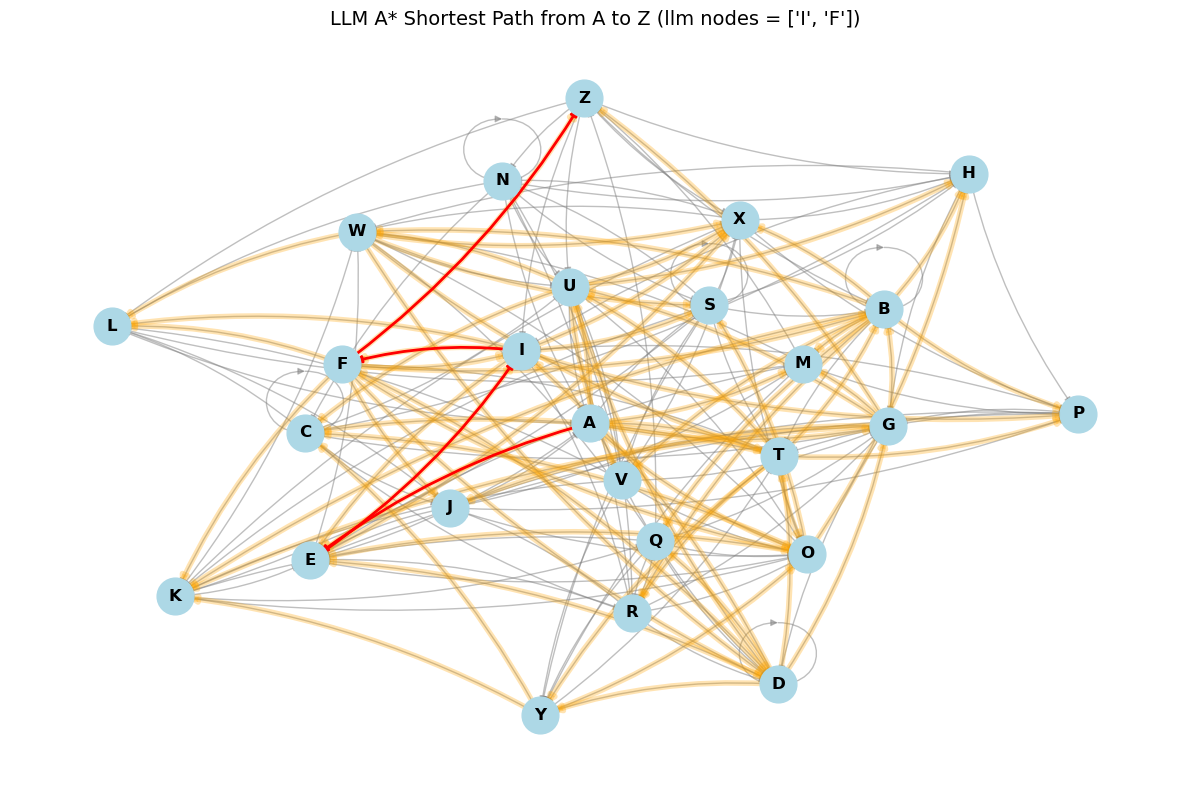

In [117]:
start, goal = 'A', 'Z'
llm_nodes = ['I','F']
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, llm_nodes)
print("Count : ",count)
print("Cost : ",cost)
print("# of Checking edges", len(checking_edges))
plot_graph(G, path=path, start=start, goal=goal, checking_edges= checking_edges, weight_tag= False, llm_nodes = llm_nodes)